In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,re
import seaborn as sns

### signature heatmap

In [44]:
import matplotlib.pyplot as plt
from matplotlib import cm
from math import log10

def signature_proportion_heatmap(sig_matrix,label_df,colorbar,sample_order,legend_title,output,format = 'png') :
    """
    Args:
        sig_matrix (pd.DataFrame): signature proportion matrix
        label_df (pd.DataFrame): dataframe with sample metadata
        colorbar (str): colnames of label_df will treat as colorbar
        sample_order (list) : specific ordered sample list
        legend_title (str): title of legend
        output (str): path of heatmap output
        format (str, optional): . Defaults to 'png'.
    """    
    metadata_df = label_df.loc[sample_order,:]
    plot_df = sig_matrix.loc[:,metadata_df.index].T
    
    cmap = sns.light_palette("darksalmon", as_cmap=True)
    #cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)
    cluster1 = metadata_df[colorbar[0]].values
    cluster1_lut = dict(zip( set(cluster1),  [cm.Set2(x) for x in range(10)] )) # type: ignore
    cluster1_colors = pd.Series(cluster1).map(cluster1_lut)
    cluster1_colors.index = metadata_df.index
    
    if len(colorbar) == 1 :
    
        g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                    row_cluster=False, 
                    col_cluster=False,
                    row_colors=[cluster1_colors[plot_df.index]],
                    linewidths=0, figsize=(6,10))
        g.ax_cbar.set_position((0.05, .3, .03, .4))# type: ignore
        g.cax.set_title("Sig proportion",fontsize = 10)# type: ignore

        for label in sorted(set(cluster1)):
            g.ax_col_dendrogram.bar(0, 0, color=cluster1_lut[label], label=label, linewidth=0.5)
        l1 = g.ax_col_dendrogram.legend(title=legend_title, loc="center", ncol=5, bbox_to_anchor=(0.5, .9), bbox_transform=plt.gcf().transFigure) # type: ignore
    else :

        cluster2 = metadata_df.loc[:,colorbar[1]].values
        cluster2_lut = dict(zip( set(cluster2),  [cm.Set3(x) for x in range(10)] ))# type: ignore
        cluster2_colors = pd.Series(cluster2).map(cluster2_lut)
        cluster2_colors.index = metadata_df.index

        cmap = sns.light_palette("darksalmon", as_cmap=True)
        #cmap = sns.diverging_palette(240, 10, n=9,as_cmap=True)

        g = sns.clustermap(plot_df, cmap=cmap,vmin=0, vmax=1,  cbar_kws={"shrink": .3},
                        row_cluster=False, 
                        col_cluster=False,
                        row_colors=[cluster1_colors[plot_df.index],cluster2_colors[plot_df.index]],
                        linewidths=0, figsize=(6,10))
        g.ax_cbar.set_position((0.05, .3, .03, .4))# type: ignore
        g.cax.set_title("Sig proportion",fontsize = 10)# type: ignore
        
        for label in sorted(set(cluster1)):
            g.ax_col_dendrogram.bar(0, 0, color=cluster1_lut[label], label=label, linewidth=0)
        l1 = g.ax_col_dendrogram.legend(title=colorbar[0] + ' ' + legend_prefix, loc="center", ncol=5, bbox_to_anchor=(0.47, 1.0), bbox_transform=plt.gcf().transFigure) # type: ignore
    
        for label in sorted(set(cluster2)):
            g.ax_row_dendrogram.bar(0, 0, color=cluster2_lut[label], label=label, linewidth=0)
        l2 = g.ax_row_dendrogram.legend(title=colorbar[1] + ' ' + legend_prefix, loc="center", ncol=5, bbox_to_anchor=(0.5, .9), bbox_transform=plt.gcf().transFigure) # type: ignore

    plt.savefig(output,dpi = 300,bbox_inches = 'tight',format = format)

In [38]:
condition = ['mci','normal']
for con in condition :
    lacto_sig_m = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3.2/%s/signature_matrix/Lactobacillus_signature_proportion_matrix.txt" % con,sep='\t',index_col=0)
    bifido_sig_m = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3.2/%s/signature_matrix/Bifidobacterium_signature_proportion_matrix.txt" % con,sep='\t',index_col=0)
    sig_m = pd.concat([lacto_sig_m,bifido_sig_m])
    sig_m = sig_m.iloc[[0,1,2,4,5,6],:]
    sig_m.to_csv("/home/bruce1996/data/MCI/manuscript_v3.2/%s/consensus_clustering/signature_proportion_matrix.txt" % con,sep='\t')

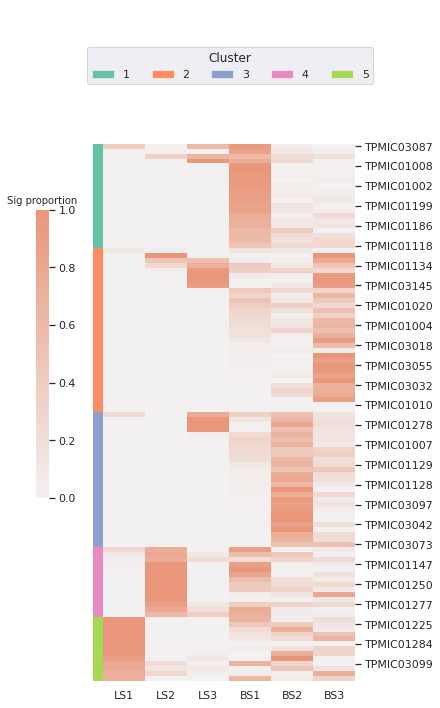

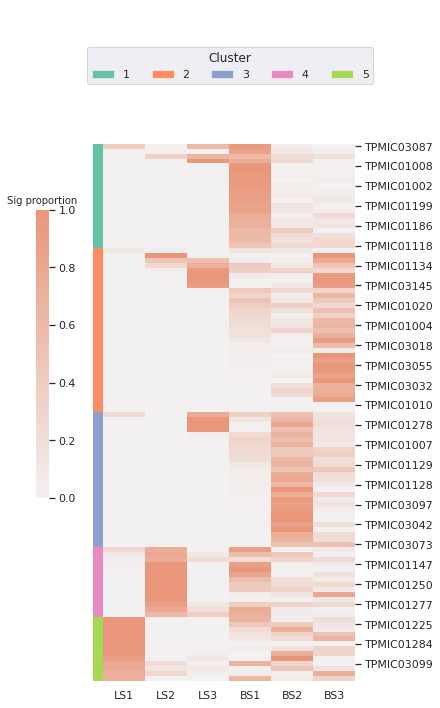

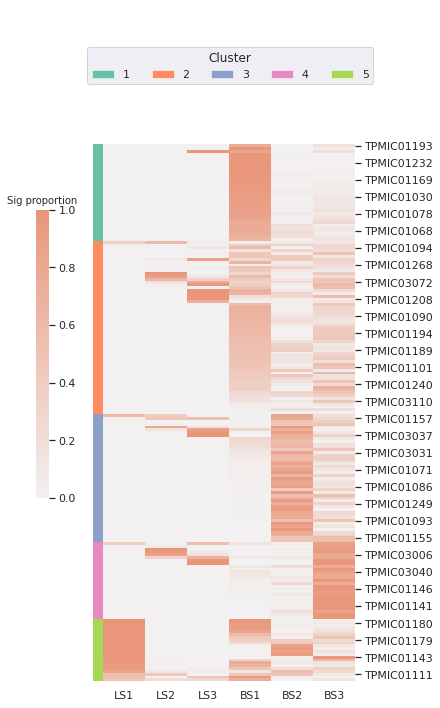

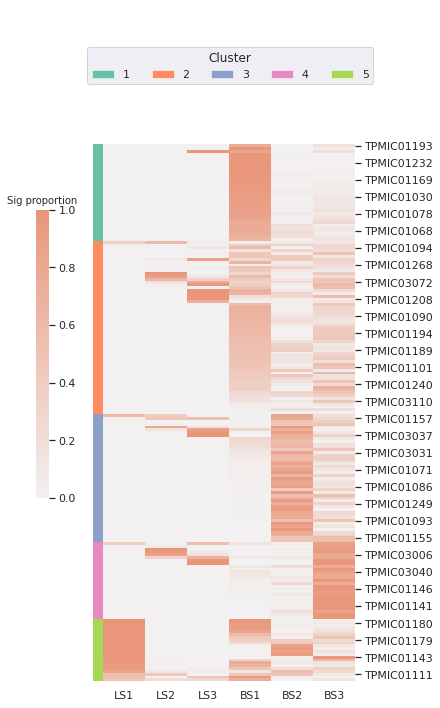

In [47]:
condition = ['mci','normal']
for con in condition :
    cluster = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3.2/%s/consensus_clustering/consensus_clustering_label.txt" % (con),sep='\t',index_col=0)
    matrix = pd.read_csv("/home/bruce1996/data/MCI/manuscript_v3.2/%s/consensus_clustering/signature_proportion_matrix.txt" % (con),sep='\t',index_col=0)
    sample = list(cluster.index)
    output_path = "/home/bruce1996/data/MCI/manuscript_v3.2/%s/consensus_clustering/" % con
    convert_dict = {key:val for key,val in [(x,100-x) for x in range(cluster['cluster'].max()+1)]}
    tmp = cluster
    tmp['reverse_order'] = tmp['cluster'].replace(convert_dict)
    order_matrix = pd.concat([tmp,matrix.T],axis=1)
    order_col = ['reverse_order'] + list(matrix.index)
    sample_order = list(order_matrix.sort_values(by=order_col ,ascending=False).index)
    matrix.index = [x.split(' ')[0][0] + x.split(' ')[1][0].upper() + x.split(' ')[1][-1] for x in matrix.index]
    signature_proportion_heatmap(matrix.loc[:,sample],cluster.loc[sample,:],['cluster'],sample_order,"Cluster",output_path + '%s_consensus_clustering_sig_proportion_heatmap.png' % con)
    signature_proportion_heatmap(matrix.loc[:,sample],cluster.loc[sample,:],['cluster'],sample_order,"Cluster",output_path + '%s_consensus_clustering_sig_proportion_heatmap.svg' % con,format='svg')